# Video Classification Tutorial

## Introduction  

In this tutorial, you will learn 
- how to perform inference with a MMAction2 recognizer
- how to train a new recognizer on customized dataset
- how to test the trained recognizer

## 1 Installation

## 1.1 Install MMAction2 in CS GPU Farm

1. Create a conda virtual environment and activate it. (Here, we assume the new environment is called ``mmaction2``)

    ```shell
    conda create -n mmaction2 python=3.7 -y
    conda activate mmaction2
    ```  
    



2. Install PyTorch and torchvision following the [official instructions](https://pytorch.org/),

    ```shell
    conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cudatoolkit=10.1 -c pytorch
    ```  



    
3. Clone the MMAction2 repository.

    ```shell
    git clone https://github.com/open-mmlab/mmaction2.git
    cd mmaction2
    ```  
    



4. Install mmcv-full from source by the following command

    ```shell
    git clone https://github.com/open-mmlab/mmcv.git
    cd mmcv
    MMCV_WITH_OPS=1 pip install -e .  # package mmcv-full will be installed after this step
    cd ..
    ```  




5. Install build requirements and then install MMAction2.

    ```shell
    pip install -r requirements.txt
    pip install einops
    pip install ipywidgets
    pip install decord
    pip install -v -e .  # or "python setup.py develop"
    ```  




6. Put this file `5_video_classification_tutorial.ipynb` in the `mmaction2` folder.

## 1.2 Check the installation

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

1.7.1 True
0.20.0
1.4.2
11.0
GCC 7.5


## 2 MMAction2 Tutorial

## 2.1 Perform inference with a MMAction2 recognizer
MMAction2 already provides high level APIs to do inference and training.

### 2.1.1 Download checkpoint

In [3]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_1x1x3_100e_kinetics400_rgb/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth \
      -O checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth

--2021-12-27 02:06:56--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_1x1x3_100e_kinetics400_rgb/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97579339 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth’

checkpoints/tsn_r50 100%[===================>]  93.06M  13.2MB/s    in 7.7s    

2021-12-27 02:07:04 (12.2 MB/s) - ‘checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth’ saved [97579339/97579339]



### 2.1.2 Inference with the recognizer

In [4]:
from mmaction.apis import inference_recognizer, init_recognizer

# Choose to use a config and initialize the recognizer
config = 'configs/recognition/tsn/tsn_r50_video_inference_1x1x3_100e_kinetics400_rgb.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'
# Initialize the recognizer
model = init_recognizer(config, checkpoint, device='cuda:0')

load checkpoint from local path: checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth


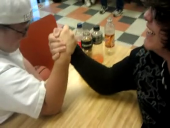

In [5]:
from IPython.display import clear_output,  display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2
import os

def show_video(video_path:str,small:int=2):
    if not os.path.exists(video_path):
        print("The video does not exist")
    video = cv2.VideoCapture(video_path)
    current_time = 0
    while(True):
        try:
            clear_output(wait=True)
            ret, frame = video.read()
            if not ret:
                break
            lines, columns, _ = frame.shape
            
            if current_time == 0:
                current_time = time.time()
            else:
                last_time = current_time
                current_time = time.time()
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
            frame = cv2.resize(frame, (int(columns / small), int(lines / small)))
            img = Image.fromarray(frame)
            
            display(img)
            time.sleep(0.001)
            
        except KeyboardInterrupt:
            video.release()


show_video('demo/demo.mp4')


In [9]:
# Use the recognizer to do inference
video = 'demo/demo.mp4'
label = 'tools/data/kinetics/label_map_k400.txt'
results = inference_recognizer(model, video, label_path=label)

# show the results
labels = open('tools/data/kinetics/label_map_k400.txt').readlines()
labels = [x.strip() for x in labels]
results = [(labels[k[0]], k[1]) for k in results]

print(f'The top-5 labels with corresponding scores are:')
for result in results:
    print(f'{result[0]}: ', result[1])

The top-5 labels with corresponding scores are:
arm wrestling:  29.616438
rock scissors paper:  10.754843
shaking hands:  9.908401
clapping:  9.189912
massaging feet:  8.305307




## 2.2 Train a new recognizer on customized dataset

To train a new recognizer, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new recognizer

### 2.2.1 Support a new dataset

In this tutorial, we gives an example to convert the data into the format of existing datasets. Other methods and more advanced usages can be found in the [doc](/docs/tutorials/new_dataset.md)

Firstly, let's download a tiny dataset obtained from [Kinetics-400](https://deepmind.com/research/open-source/open-source-datasets/kinetics/). We select 30 videos with their labels as train dataset and 10 videos with their labels as test dataset.

In [10]:
# download, decompress the data
!rm kinetics400_tiny.zip*
!rm -rf kinetics400_tiny
!wget https://download.openmmlab.com/mmaction/kinetics400_tiny.zip
!unzip kinetics400_tiny.zip > /dev/null

rm: cannot remove 'kinetics400_tiny.zip*': No such file or directory
--2021-12-27 02:25:58--  https://download.openmmlab.com/mmaction/kinetics400_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18308682 (17M) [application/zip]
Saving to: ‘kinetics400_tiny.zip’

kinetics400_tiny.zi 100%[===================>]  17.46M  14.0MB/s    in 1.2s    

2021-12-27 02:26:01 (14.0 MB/s) - ‘kinetics400_tiny.zip’ saved [18308682/18308682]



**Check the directory structure of the tiny data**
```
kinetics400_tiny
├── kinetics_tiny_train_video.txt
├── kinetics_tiny_val_video.txt
├── train
│   ├── 27_CSXByd3s.mp4
│   ├── 34XczvTaRiI.mp4
│   ├── A-wiliK50Zw.mp4
│   ├── D32_1gwq35E.mp4
│   ├── D92m0HsHjcQ.mp4
│   ├── DbX8mPslRXg.mp4
│   ├── FMlSTTpN3VY.mp4
│   ├── h10B9SVE-nk.mp4
│   ├── h2YqqUhnR34.mp4
│   ├── iRuyZSKhHRg.mp4
│   ├── IyfILH9lBRo.mp4
│   ├── kFC3KY2bOP8.mp4
│   ├── LvcFDgCAXQs.mp4
│   ├── O46YA8tI530.mp4
│   ├── oMrZaozOvdQ.mp4
│   ├── oXy-e_P_cAI.mp4
│   ├── P5M-hAts7MQ.mp4
│   ├── phDqGd0NKoo.mp4
│   ├── PnOe3GZRVX8.mp4
│   ├── R8HXQkdgKWA.mp4
│   ├── RqnKtCEoEcA.mp4
│   ├── soEcZZsBmDs.mp4
│   ├── TkkZPZHbAKA.mp4
│   ├── T_TMNGzVrDk.mp4
│   ├── WaS0qwP46Us.mp4
│   ├── Wh_YPQdH1Zg.mp4
│   ├── WWP5HZJsg-o.mp4
│   ├── xGY2dP0YUjA.mp4
│   ├── yLC9CtWU5ws.mp4
│   └── ZQV4U2KQ370.mp4
└── val
    ├── 0pVGiAU6XEA.mp4
    ├── AQrbRSnRt8M.mp4
    ├── b6Q_b7vgc7Q.mp4
    ├── ddvJ6-faICE.mp4
    ├── IcLztCtvhb8.mp4
    ├── ik4BW3-SCts.mp4
    ├── jqRrH30V0k4.mp4
    ├── SU_x2LQqSLs.mp4
    ├── u4Rm6srmIS8.mp4
    └── y5Iu7XkTqV0.mp4
```


**Check annotation format**    
According to the format defined in [`VideoDataset`](./datasets/video_dataset.py), each line indicates a sample video with the filepath and label, which are split with a whitespace.

In [11]:
# After downloading the data, we need to check the annotation format
print("Train annotations: ")
!cat kinetics400_tiny/kinetics_tiny_train_video.txt
print("\nVal annotations: ")
!cat kinetics400_tiny/kinetics_tiny_val_video.txt

Train annotations: 
D32_1gwq35E.mp4 0
iRuyZSKhHRg.mp4 1
oXy-e_P_cAI.mp4 0
34XczvTaRiI.mp4 1
h2YqqUhnR34.mp4 0
O46YA8tI530.mp4 0
kFC3KY2bOP8.mp4 1
WWP5HZJsg-o.mp4 1
phDqGd0NKoo.mp4 1
yLC9CtWU5ws.mp4 0
27_CSXByd3s.mp4 1
IyfILH9lBRo.mp4 1
T_TMNGzVrDk.mp4 1
TkkZPZHbAKA.mp4 0
PnOe3GZRVX8.mp4 1
soEcZZsBmDs.mp4 1
FMlSTTpN3VY.mp4 1
WaS0qwP46Us.mp4 0
A-wiliK50Zw.mp4 1
oMrZaozOvdQ.mp4 1
ZQV4U2KQ370.mp4 0
DbX8mPslRXg.mp4 1
h10B9SVE-nk.mp4 1
P5M-hAts7MQ.mp4 0
R8HXQkdgKWA.mp4 0
D92m0HsHjcQ.mp4 0
RqnKtCEoEcA.mp4 0
LvcFDgCAXQs.mp4 0
xGY2dP0YUjA.mp4 0
Wh_YPQdH1Zg.mp4 0

Val annotations: 
ddvJ6-faICE.mp4 1
jqRrH30V0k4.mp4 0
SU_x2LQqSLs.mp4 0
b6Q_b7vgc7Q.mp4 0
y5Iu7XkTqV0.mp4 1
u4Rm6srmIS8.mp4 0
ik4BW3-SCts.mp4 1
0pVGiAU6XEA.mp4 0
AQrbRSnRt8M.mp4 1
IcLztCtvhb8.mp4 1


### 2.2.2 Train a new TSN recognizer

In [12]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist, set_random_seed
from mmcv.utils import get_git_hash

from mmaction import __version__
from mmaction.apis import train_model
from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.utils import collect_env, get_root_logger, register_module_hooks


def parse_args():
    parser = argparse.ArgumentParser(description='Train a recognizer')
    parser.add_argument('--config', default='configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py',
                                    help='train config file path')
    parser.add_argument('--work-dir', default='work_dirs/tutorial_tsn_kinetics_tiny', help='the dir to save logs and models')
    parser.add_argument(
        '--resume-from', help='the checkpoint file to resume from')
    parser.add_argument(
        '--no-validate',
        action='store_true',
        help='whether not to evaluate the checkpoint during training')
    group_gpus = parser.add_mutually_exclusive_group()
    group_gpus.add_argument(
        '--gpus',
        type=int,
        help='number of gpus to use '
        '(only applicable to non-distributed training)')
    group_gpus.add_argument(
        '--gpu-ids',
        type=int,
        nargs='+',
        help='ids of gpus to use '
        '(only applicable to non-distributed training)')
    parser.add_argument('--seed', type=int, default=2021, help='random seed')
    parser.add_argument(
        '--deterministic',
        action='store_true',
        help='whether to set deterministic options for CUDNN backend.')
    parser.add_argument(
        '--cfg-options',
        nargs='+',
        action=DictAction,
        help='override some settings in the used config, the key-value pair '
        'in xxx=yyy format will be merged into config file.')
    parser.add_argument(
        '--launcher',
        choices=['none', 'pytorch', 'slurm', 'mpi'],
        default='none',
        help='job launcher')
    parser.add_argument('--local_rank', type=int, default=0)
    args = parser.parse_args(args=[])
    if 'LOCAL_RANK' not in os.environ:
        os.environ['LOCAL_RANK'] = str(args.local_rank)

    return args


def main():
    args = parse_args()

    cfg = Config.fromfile(args.config)
    if args.cfg_options is not None:
        cfg.merge_from_dict(args.cfg_options)
    
    # ------------------------------------------------------------------------
    # Modify dataset type and path
    cfg.dataset_type = 'VideoDataset'
    cfg.data_root = 'kinetics400_tiny/train/'
    cfg.data_root_val = 'kinetics400_tiny/val/'
    cfg.ann_file_train = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
    cfg.ann_file_val = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
    cfg.ann_file_test = 'kinetics400_tiny/kinetics_tiny_val_video.txt'

    cfg.data.test.type = 'VideoDataset'
    cfg.data.test.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
    cfg.data.test.data_prefix = 'kinetics400_tiny/val/'

    cfg.data.train.type = 'VideoDataset'
    cfg.data.train.ann_file = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
    cfg.data.train.data_prefix = 'kinetics400_tiny/train/'

    cfg.data.val.type = 'VideoDataset'
    cfg.data.val.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
    cfg.data.val.data_prefix = 'kinetics400_tiny/val/'

    # Modify num classes of the model in cls_head
    cfg.model.cls_head.num_classes = 2
    # We can use the pre-trained TSN model
    cfg.load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'

    # Set up working dir to save files and logs.
    cfg.work_dir = 'work_dirs/tutorial_tsn_kinetics_tiny'

    # The original learning rate (LR) is set for 8-GPU training.
    # We divide it by 8 since we only use one GPU.
    cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
    cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
    cfg.total_epochs = 20

    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 5
    # We can set the log print interval to reduce the the times of printing log
    cfg.log_config.interval = 5

    # Set seed thus the results are more reproducible
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # Save the best
    cfg.evaluation.save_best='auto'
    
    # --------------------------------------------------------------------------
    # Setup environment
    # set cudnn_benchmark
    if cfg.get('cudnn_benchmark', False):
        torch.backends.cudnn.benchmark = True

    # work_dir is determined in this priority:
    # CLI > config file > default (base filename)
    if args.work_dir is not None:
        # update configs according to CLI args if args.work_dir is not None
        cfg.work_dir = args.work_dir
    elif cfg.get('work_dir', None) is None:
        # use config filename as default work_dir if cfg.work_dir is None
        cfg.work_dir = osp.join('./work_dirs',
                                osp.splitext(osp.basename(args.config))[0])
    if args.resume_from is not None:
        cfg.resume_from = args.resume_from
    if args.gpu_ids is not None:
        cfg.gpu_ids = args.gpu_ids
    else:
        cfg.gpu_ids = range(1) if args.gpus is None else range(args.gpus)

    # init distributed env first, since logger depends on the dist info.
    if args.launcher == 'none':
        distributed = False
    else:
        distributed = True
        init_dist(args.launcher, **cfg.dist_params)
        _, world_size = get_dist_info()
        cfg.gpu_ids = range(world_size)

    # The flag is used to determine whether it is omnisource training
    cfg.setdefault('omnisource', False)

    # The flag is used to register module's hooks
    cfg.setdefault('module_hooks', [])

    # create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    # dump config
    cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
    # init logger before other steps
    timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
    log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
    logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

    # init the meta dict to record some important information such as
    # environment info and seed, which will be logged
    meta = dict()
    # log env info
    env_info_dict = collect_env()
    env_info = '\n'.join([f'{k}: {v}' for k, v in env_info_dict.items()])
    dash_line = '-' * 60 + '\n'
    logger.info('Environment info:\n' + dash_line + env_info + '\n' +
                dash_line)
    meta['env_info'] = env_info

    # log some basic info
    logger.info(f'Distributed training: {distributed}')
    logger.info(f'Config: {cfg.pretty_text}')

    # set random seeds
    if args.seed is not None:
        logger.info(f'Set random seed to {args.seed}, '
                    f'deterministic: {args.deterministic}')
        set_random_seed(args.seed, deterministic=args.deterministic)
    cfg.seed = args.seed
    meta['seed'] = args.seed
    meta['config_name'] = osp.basename(args.config)
    meta['work_dir'] = osp.basename(cfg.work_dir.rstrip('/\\'))
    
    # ----------------------------------------------------------------------------
    # Build model
    model = build_model(
        cfg.model,
        train_cfg=cfg.get('train_cfg'),
        test_cfg=cfg.get('test_cfg'))

    # Build dataset
    datasets = [build_dataset(cfg.data.train)]

    if len(cfg.workflow) == 2:
        val_dataset = copy.deepcopy(cfg.data.val)
        datasets.append(build_dataset(val_dataset))
    if cfg.checkpoint_config is not None:
        # save mmaction version, config file content and class names in
        # checkpoints as meta data
        cfg.checkpoint_config.meta = dict(
            mmaction_version=__version__ + get_git_hash(digits=7),
            config=cfg.pretty_text)


    train_model(
        model,
        datasets,
        cfg,
        distributed=distributed,
        validate=(not args.no_validate),
        timestamp=timestamp,
        meta=meta)


if __name__ == '__main__':
    main()


2021-12-27 02:30:28,772 - mmaction - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.11 (default, Jul 27 2021, 14:32:16) [GCC 7.5.0]
CUDA available: True
GPU 0: GeForce RTX 2080 Ti
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.7.1
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.6.0 (Git Hash 5ef631a030a6f73131c77892041042805a06064f)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arc

load checkpoint from torchvision path: torchvision://resnet50


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /userhome/cs/wjn922/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-12-27 02:30:32,119 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2021-12-27 02:30:32,676 - mmaction - INFO - load checkpoint from local path: ./checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth
2021-12-27 02:30:32,810 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([2]).
2021-12-27 02:30:32,813 - mmaction - INFO - Start running, host: wjn922@gpu2-comp-110, work_dir: /userhome/cs/wjn922/mmaction2/work_dirs/tutorial_tsn_kinetics_tiny
2021-12-27 02:30:32,815 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook             

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.5 task/s, elapsed: 2s, ETA:     0s

2021-12-27 02:31:03,252 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-12-27 02:31:03,254 - mmaction - INFO - 
top1_acc	0.9000
top5_acc	1.0000
2021-12-27 02:31:03,255 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-12-27 02:31:03,257 - mmaction - INFO - 
mean_acc	0.9000
2021-12-27 02:31:04,095 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-12-27 02:31:04,096 - mmaction - INFO - Best top1_acc is 0.9000 at 5 epoch.
2021-12-27 02:31:04,098 - mmaction - INFO - Epoch(val) [5][5]	top1_acc: 0.9000, top5_acc: 1.0000, mean_class_accuracy: 0.9000
2021-12-27 02:31:07,455 - mmaction - INFO - Epoch [6][5/15]	lr: 7.813e-05, eta: 0:01:24, time: 0.670, data_time: 0.572, memory: 3206, top1_acc: 0.7000, top5_acc: 1.0000, loss_cls: 0.6112, loss: 0.6112, grad_norm: 10.2684
2021-12-27 02:31:08,578 - mmaction - INFO - Epoch [6][10/15]	lr: 7.813e-05, eta: 0:01:20, time: 0.225, data_time: 0.138, memory: 3206, top1_acc: 0.5000, top5_acc: 1.0000, loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.9 task/s, elapsed: 2s, ETA:     0s

2021-12-27 02:31:34,081 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-12-27 02:31:34,083 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-12-27 02:31:34,084 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-12-27 02:31:34,085 - mmaction - INFO - 
mean_acc	1.0000
2021-12-27 02:31:34,102 - mmaction - INFO - The previous best checkpoint /userhome/cs/wjn922/mmaction2/work_dirs/tutorial_tsn_kinetics_tiny/best_top1_acc_epoch_5.pth was removed
2021-12-27 02:31:34,908 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-12-27 02:31:34,909 - mmaction - INFO - Best top1_acc is 1.0000 at 10 epoch.
2021-12-27 02:31:34,910 - mmaction - INFO - Epoch(val) [10][5]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000
2021-12-27 02:31:38,569 - mmaction - INFO - Epoch [11][5/15]	lr: 7.813e-05, eta: 0:00:54, time: 0.731, data_time: 0.642, memory: 3206, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5542, loss: 0.5542, grad_norm: 9.990

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.0 task/s, elapsed: 2s, ETA:     0s

2021-12-27 02:32:05,512 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-12-27 02:32:05,514 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-12-27 02:32:05,516 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-12-27 02:32:05,518 - mmaction - INFO - 
mean_acc	1.0000
2021-12-27 02:32:05,519 - mmaction - INFO - Epoch(val) [15][5]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000
2021-12-27 02:32:09,147 - mmaction - INFO - Epoch [16][5/15]	lr: 7.813e-05, eta: 0:00:26, time: 0.724, data_time: 0.629, memory: 3206, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.4103, loss: 0.4103, grad_norm: 7.5180
2021-12-27 02:32:10,151 - mmaction - INFO - Epoch [16][10/15]	lr: 7.813e-05, eta: 0:00:24, time: 0.201, data_time: 0.106, memory: 3206, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5766, loss: 0.5766, grad_norm: 10.6767
2021-12-27 02:32:11,165 - mmaction - INFO - Epoch [16][15/15]	lr: 7.813e-05, eta: 0:00:21, time: 0.203, data_time: 0.115, memory: 3206, to

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.5 task/s, elapsed: 2s, ETA:     0s

2021-12-27 02:32:35,932 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-12-27 02:32:35,934 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-12-27 02:32:35,934 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-12-27 02:32:35,936 - mmaction - INFO - 
mean_acc	1.0000
2021-12-27 02:32:35,937 - mmaction - INFO - Epoch(val) [20][5]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000


### Understand the log
From the log, we can have a basic understanding the training process and know how well the recognizer is trained.

**Firstly**, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `fc.bias` and `fc.weight`.

**Second**, since the dataset we are using is small, we loaded a TSN model and finetune it for action recognition.
The original TSN is trained on original Kinetics-400 dataset which contains 400 classes but Kinetics-400 Tiny dataset only have 2 classes. Therefore, the last FC layer of the pre-trained TSN for classification has different weight shape and is not used.

**Third**, after training, the recognizer is evaluated by the default evaluation. The results show that the recognizer achieves 100% top1 accuracy and 100% top5 accuracy on the val dataset.

## 2.3 Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [13]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmcv import Config
from mmcv.runner import set_random_seed
from mmcv.runner import load_checkpoint

# -----------------------------------------------------------------------------------
# Load the config file
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'kinetics400_tiny/train/'
cfg.data_root_val = 'kinetics400_tiny/val/'
cfg.ann_file_train = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
cfg.ann_file_val = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.ann_file_test = 'kinetics400_tiny/kinetics_tiny_val_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.data.test.data_prefix = 'kinetics400_tiny/val/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
cfg.data.train.data_prefix = 'kinetics400_tiny/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.data.val.data_prefix = 'kinetics400_tiny/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)

# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 2

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/tutorial_tsn_kinetics_tiny'

# --------------------------------------------------------------------
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# Build the recognizer and load the checkpoint
checkpoint = 'work_dirs/tutorial_tsn_kinetics_tiny/latest.pth'
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
load_checkpoint(model, checkpoint, map_location='cpu')

model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')



load checkpoint from torchvision path: torchvision://resnet50


2021-12-27 02:33:05,847 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}


load checkpoint from local path: work_dirs/tutorial_tsn_kinetics_tiny/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 2.4 task/s, elapsed: 4s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	1.0000
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	1.0000
top1_acc: 1.0000
top5_acc: 1.0000
mean_class_accuracy: 1.0000


## Project Introduction

- Train a I3D recognizer on the HMDB51 dataset.
- For efficient training, you can finetune the I3D model pretrained on Kinetics-400.
- To achieve this, you need to modify the head, dataset config and training schedule.
- Bonus: implmenting the non-local block and adding it to the I3D model.